In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

In [2]:

class CNN_default(nn.Module):
    def __init__(self, optimizer_type, learning_rate):
        super(CNN_default, self).__init__()
        self.optimizer_type = optimizer_type
        self.learning_rate = learning_rate
        self.loss_function = nn.CrossEntropyLoss()
        
    def forward(self, x):
        return x
    
    def fit(self, train_loader, epochs):
        optimizer = self.optimizer_type(self.parameters(), lr=self.learning_rate)
        self.train()
        
        for images, labels in train_loader:
            # Прямой проход
            outputs = self(images)
            loss = self.loss_function(outputs, labels)
            
            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()
        
    def evaluate(self, test_loader):
        correct = 0
        total = 0

        total_loss = 0
        
        self.eval()
        
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = self(images)
                
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                loss = self.loss_function(outputs, labels)
                total_loss += loss.item()
        
        return correct / total, total_loss / len(test_loader)

In [3]:

class LeNet(CNN_default):
    def __init__(self, optimizer, learning_rate):
        super(LeNet, self).__init__(optimizer, learning_rate)
        
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [4]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

MNIST_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
MNIST_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

MNIST_train_loader = DataLoader(MNIST_train_dataset, batch_size=32, shuffle=True)
MNIST_test_loader = DataLoader(MNIST_test_dataset, batch_size=32, shuffle=False)

print(f"Размер обучающего датасета: {len(MNIST_train_dataset)}")
print(f"Размер тестового датасета: {len(MNIST_test_dataset)}")

Размер обучающего датасета: 60000
Размер тестового датасета: 10000


In [5]:
LeNet_SGD_accuracies = []
LeNet_SGD_losses = []

LeNet_SGD_model = LeNet(optim.SGD, learning_rate=1e-6)
for _ in range(10):
    LeNet_SGD_model.fit(MNIST_train_loader, epochs=1)
    accurace, losses = LeNet_SGD_model.evaluate(MNIST_test_loader)
    LeNet_SGD_accuracies.append(accurace)
    LeNet_SGD_losses.append(losses)
    print(accurace, losses)

0.1135 2.300181971571316
0.1135 2.291385365751224
0.2316 2.2503571853089257
0.5601 1.4648415444377132
0.8293 1.0609404945600267
0.8424 0.606728948985997
0.8826 0.43743333618599956
0.9 0.3315431561630469
0.9245 0.2563145027641719
0.9346 0.23429810516714764


In [20]:
LeNet_AdaDelta_accuracies = []
LeNet_AdaDelta_losses = []

LeNet_AdaDelta_model = LeNet(optim.Adadelta, learning_rate=1e-4)
for _ in range(10):
    LeNet_AdaDelta_model.fit(MNIST_train_loader, epochs=1)
    accurace, losses = LeNet_AdaDelta_model.evaluate(MNIST_test_loader)
    LeNet_AdaDelta_accuracies.append(accurace)
    LeNet_AdaDelta_losses.append(losses)
    print(accurace, losses)

0.7791 0.6923913717888796
0.8902 0.36796900161062945
0.9164 0.2878927570461227
0.928 0.24489917110996887
0.9354 0.21792313999410112
0.9414 0.19514389620192302
0.945 0.1774435628096933
0.9492 0.1627907680560308
0.953 0.1485187959531471
0.9586 0.13785374972644968


In [35]:
LeNet_NAG_accuracies = []
LeNet_NAG_losses = []

LeNet_NAG_model = LeNet(lambda params, lr: optim.SGD(params, lr=lr, momentum=.9, nesterov=True), learning_rate=1e-7)
for _ in range(10):
    LeNet_NAG_model.fit(MNIST_train_loader, epochs=1)
    accurace, losses = LeNet_NAG_model.evaluate(MNIST_test_loader)
    LeNet_NAG_accuracies.append(accurace)
    LeNet_NAG_losses.append(losses)
    print(accurace, losses)

0.1865 2.290434457242679
0.1731 2.1839476096363493
0.7266 0.9593774880083225
0.6143 1.1963082850931552
0.8213 0.6074820592666206
0.8587 0.4522939240827728
0.8655 0.4063491128004207
0.8722 0.4966882109439697
0.897 0.4035533745951665
0.8949 0.388059631031685


In [31]:
LeNet_Adam_accuracies = []
LeNet_Adam_losses = []

LeNet_Adam_model = LeNet(optim.Adam, learning_rate=1e-5)
for _ in range(10):
    LeNet_Adam_model.fit(MNIST_train_loader, epochs=1)
    accurace, losses = LeNet_Adam_model.evaluate(MNIST_test_loader)
    LeNet_Adam_accuracies.append(accurace)
    LeNet_Adam_losses.append(losses)
    print(accurace, losses)

0.8064 0.655617432567639
0.8998 0.3475133115098404
0.938 0.20341011335011036
0.9576 0.13808881198673453
0.9645 0.11373300746412607
0.968 0.10118985265606274
0.9741 0.08386215973310615
0.9761 0.07855136757593799
0.978 0.07325138109807161
0.9806 0.0703108154883385


In [9]:
epoch_list = list(range(10))

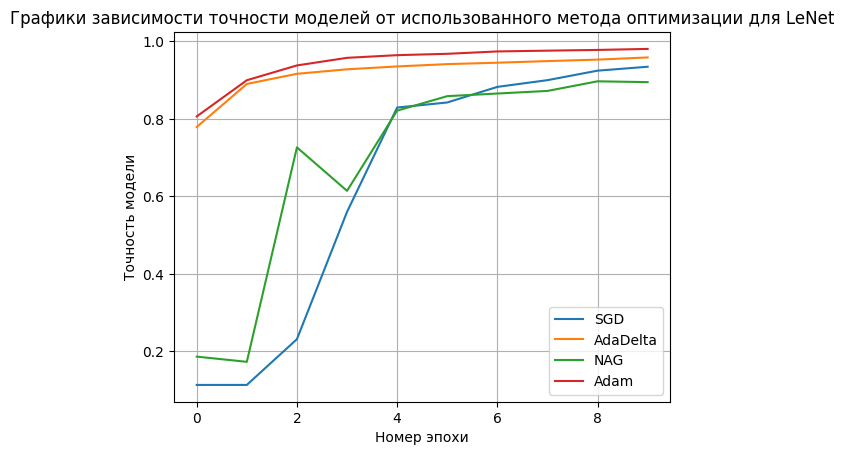

In [36]:
plt.plot(epoch_list, LeNet_SGD_accuracies, label="SGD")
plt.plot(epoch_list, LeNet_AdaDelta_accuracies, label="AdaDelta")
plt.plot(epoch_list, LeNet_NAG_accuracies, label="NAG")
plt.plot(epoch_list, LeNet_Adam_accuracies, label="Adam")

plt.title("Графики зависимости точности моделей от использованного метода оптимизации для LeNet")
plt.xlabel("Номер эпохи")
plt.ylabel("Точность модели")
plt.grid(True)
plt.legend()
plt.show()

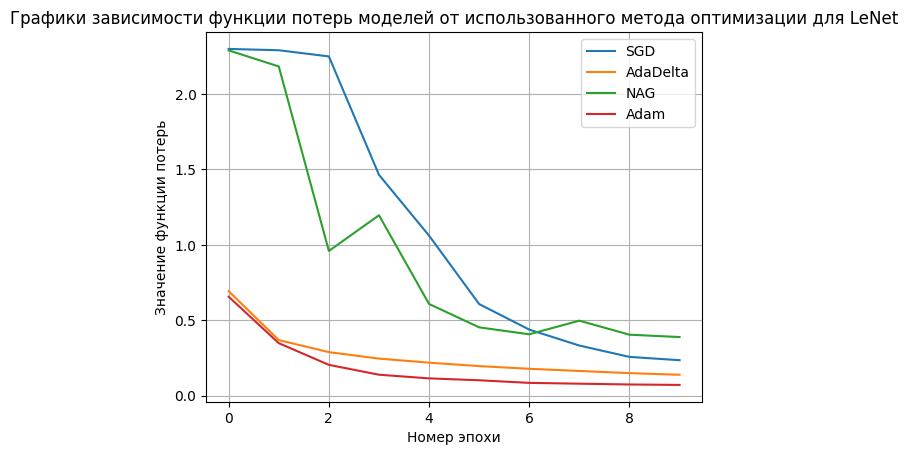

In [37]:
plt.plot(epoch_list, LeNet_SGD_losses, label="SGD")
plt.plot(epoch_list, LeNet_AdaDelta_losses, label="AdaDelta")
plt.plot(epoch_list, LeNet_NAG_losses, label="NAG")
plt.plot(epoch_list, LeNet_Adam_losses, label="Adam")

plt.title("Графики зависимости функции потерь моделей от использованного метода оптимизации для LeNet")
plt.xlabel("Номер эпохи")
plt.ylabel("Значение функции потерь")
plt.grid(True)
plt.legend()
plt.show()

In [12]:
class VGG16(CNN_default):
    def __init__(self, optimizer, learning_rate):
        super(VGG16, self).__init__(optimizer, learning_rate)
        
        self.conv1_1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv3_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(512 * 3 * 3, 1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

In [16]:

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

CIFAR10_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
CIFAR10_test_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)

CIFAR10_train_loader = DataLoader(CIFAR10_train_dataset, batch_size=32, num_workers=6, shuffle=True)
CIFAR10_test_loader = DataLoader(CIFAR10_test_dataset, batch_size=32, num_workers=6, shuffle=False)

print(f"Размер обучающего набора: {len(CIFAR10_train_dataset)}")
print(f"Размер тестового набора: {len(CIFAR10_test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Размер обучающего набора: 50000
Размер тестового набора: 50000


In [21]:
VGG16_SGD_accuracies = []
VGG16_SGD_losses = []

VGG16_SGD_model = VGG16(optim.SGD, learning_rate=1e-4)
for _ in range(10):
    VGG16_SGD_model.fit(CIFAR10_train_loader, epochs=1)
    accurace, losses = VGG16_SGD_model.evaluate(CIFAR10_test_loader)
    VGG16_SGD_accuracies.append(accurace)
    VGG16_SGD_losses.append(losses)
    print(accurace, losses)

0.22092 2.0766691035821663
0.2884 1.8316431224002947
0.40504 1.5859983528720516
0.42054 1.554516058813206
0.36066 1.6961149360915444
0.2606 2.009810331076746
0.13312 2.298340427974669
0.10044 2.320521806038425
0.1 2.312950232207432
0.1 2.307925526331574


In [22]:
VGG16_AdaDelta_accuracies = []
VGG16_AdaDelta_losses = []

VGG16_AdaDelta_model = VGG16(optim.Adadelta, learning_rate=1e-4)
for _ in range(10):
    VGG16_AdaDelta_model.fit(CIFAR10_train_loader, epochs=1)
    accurace, losses = VGG16_AdaDelta_model.evaluate(CIFAR10_test_loader)
    VGG16_AdaDelta_accuracies.append(accurace)
    VGG16_AdaDelta_losses.append(losses)
    print(accurace, losses)

0.17108 2.175093213183256
0.26268 1.9212916290920206
0.31352 1.7733054052006336
0.3833 1.6240511180800805
0.42438 1.5186642360321163
0.48102 1.4018431514482503
0.52668 1.2797025572162977
0.55322 1.211421583717783
0.59626 1.092539373873444
0.62604 1.0278772569129808


In [40]:
VGG16_NAG_accuracies = []
VGG16_NAG_losses = []

VGG16_NAG_model = VGG16(lambda params, lr: optim.SGD(params, lr=lr, momentum=.9, nesterov=True), learning_rate=1e-6)
for _ in range(10):
    VGG16_NAG_model.fit(CIFAR10_train_loader, epochs=1)
    accurace, losses = VGG16_NAG_model.evaluate(CIFAR10_test_loader)
    VGG16_NAG_accuracies.append(accurace)
    VGG16_NAG_losses.append(losses)
    print(accurace, losses)

0.14388 2.301754876122746
0.1351 2.2880770255569
0.19142 2.148381202707516
0.1988 2.074004331690641
0.20896 2.1411729007673355
0.22188 2.0328550979409243
0.22726 2.0685506699105067
0.22098 2.00868051065822
0.2472 1.90464291073768
0.26624 1.863580071232064


In [41]:
VGG16_Adam_accuracies = []
VGG16_Adam_losses = []

VGG16_Adam_model = VGG16(optim.Adam, learning_rate=1e-7)
for _ in range(10):
    VGG16_Adam_model.fit(CIFAR10_train_loader, epochs=1)
    accurace, losses = VGG16_Adam_model.evaluate(CIFAR10_test_loader)
    VGG16_Adam_accuracies.append(accurace)
    VGG16_Adam_losses.append(losses)
    print(accurace, losses)

0.167 2.2958907533439397
0.19814 2.261841870086436
0.21786 2.1749565871343046
0.23224 2.0891468492899654
0.24298 2.0364562761150564
0.23834 2.0279205419738098
0.24946 1.9961558777936665
0.2596 1.9679945981128812
0.27228 1.9329513637819735
0.2828 1.8989694708063294


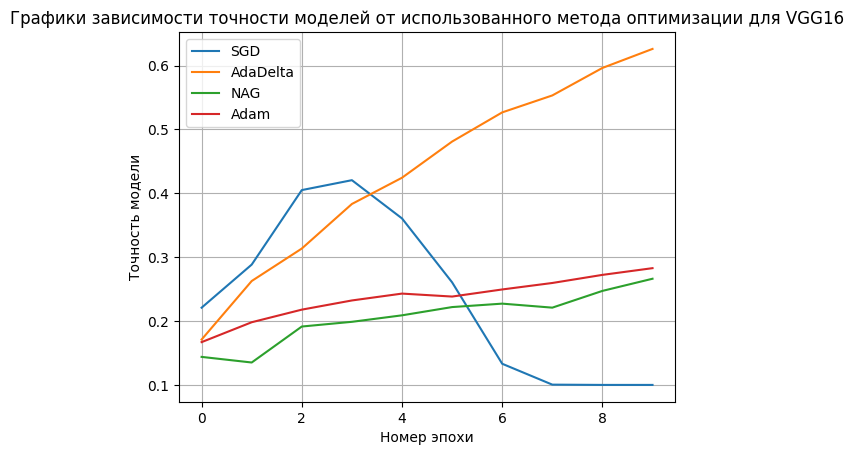

In [42]:
plt.plot(epoch_list, VGG16_SGD_accuracies, label="SGD")
plt.plot(epoch_list, VGG16_AdaDelta_accuracies, label="AdaDelta")
plt.plot(epoch_list, VGG16_NAG_accuracies, label="NAG")
plt.plot(epoch_list, VGG16_Adam_accuracies, label="Adam")

plt.title("Графики зависимости точности моделей от использованного метода оптимизации для VGG16")
plt.xlabel("Номер эпохи")
plt.ylabel("Точность модели")
plt.grid(True)
plt.legend()
plt.show() 

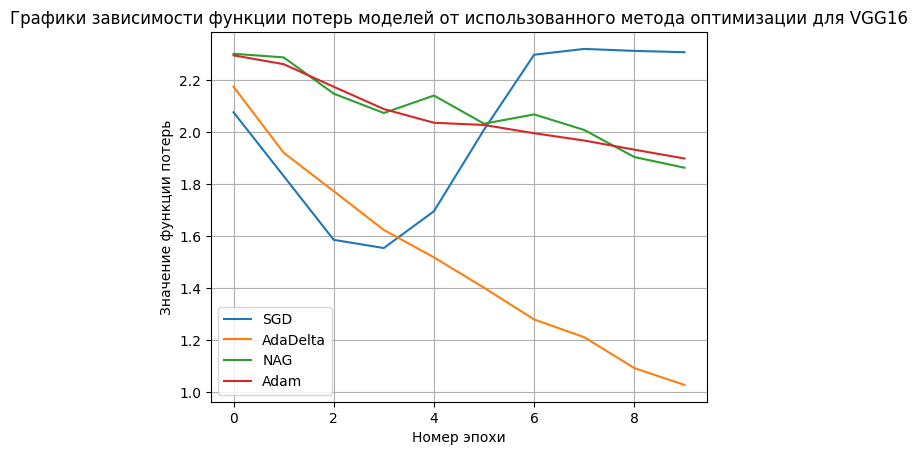

In [43]:
plt.plot(epoch_list, VGG16_SGD_losses, label="SGD")
plt.plot(epoch_list, VGG16_AdaDelta_losses, label="AdaDelta")
plt.plot(epoch_list, VGG16_NAG_losses, label="NAG")
plt.plot(epoch_list, VGG16_Adam_losses, label="Adam")

plt.title("Графики зависимости функции потерь моделей от использованного метода оптимизации для VGG16")
plt.xlabel("Номер эпохи")
plt.ylabel("Значение функции потерь")
plt.grid(True)
plt.legend()
plt.show()

In [73]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class ResNet34(CNN_default):
    def __init__(self, optimizer, learning_rate):
        super(ResNet34, self).__init__(optimizer, learning_rate)
        self.num_classes = 10
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicBlock, 64, 3)
        self.layer2 = self._make_layer(BasicBlock, 128, 4, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 6, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, self.num_classes)

        self._initialize_weights()

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []

        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [82]:
from sklearn.model_selection import train_test_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((.4772, .4505, .4168), (.2307, .2271, .2288))
])

ImageNet_dataset = datasets.ImageFolder(root='./data/imagenet', transform=transform)

train_indices, test_indices = train_test_split(list(range(len(ImageNet_dataset))), test_size=.1, random_state=42)

train_dataset = Subset(ImageNet_dataset, train_indices)
test_dataset = Subset(ImageNet_dataset, test_indices)

ImageNet_train_loader = DataLoader(train_dataset, num_workers=6, shuffle=True)
ImageNet_test_loader = DataLoader(test_dataset, num_workers=6, shuffle=False)

print(f"Размер обучающего набора: {len(ImageNet_train_loader)}")
print(f"Размер тестового набора: {len(ImageNet_test_loader)}")

Размер обучающего набора: 11624
Размер тестового набора: 1292


In [ ]:
ResNet34_SGD_accuracies = []
ResNet34_SGD_losses = []

ResNet34_SGD_model = ResNet34(optim.SGD, learning_rate=1e-7)
for _ in range(10):
    ResNet34_SGD_model.fit(ImageNet_train_loader, epochs=1)
    accurace, losses = ResNet34_SGD_model.evaluate(ImageNet_test_loader)
    ResNet34_SGD_accuracies.append(accurace)
    ResNet34_SGD_losses.append(losses)
    print(accurace, losses)

In [ ]:
ResNet34_AdaDelta_accuracies = []
ResNet34_AdaDelta_losses = []

ResNet34_AdaDelta_model = ResNet34(optim.Adadelta, learning_rate=1e-4)
for _ in range(10):
    ResNet34_AdaDelta_model.fit(ImageNet_train_loader, epochs=1)
    accurace, losses = ResNet34_AdaDelta_model.evaluate(ImageNet_test_loader)
    ResNet34_AdaDelta_accuracies.append(accurace)
    ResNet34_AdaDelta_losses.append(losses)
    print(accurace, losses)

In [ ]:
ResNet34_NAG_accuracies = []
ResNet34_NAG_losses = []

ResNet34_NAG_model = ResNet34(lambda params, lr: optim.SGD(params, lr=lr, momentum=.9, nesterov=True), learning_rate=1e-8)
for _ in range(10):
    ResNet34_NAG_model.fit(ImageNet_train_loader, epochs=1)
    accurace, losses = ResNet34_NAG_model.evaluate(ImageNet_test_loader)
    ResNet34_NAG_accuracies.append(accurace)
    ResNet34_NAG_losses.append(losses)
    print(accurace, losses)

In [ ]:
ResNet34_Adam_accuracies = []
ResNet34_Adam_losses = []

ResNet34_Adam_model = ResNet34(optim.Adam, learning_rate=1e-5)
for _ in range(10):
    ResNet34_Adam_model.fit(ImageNet_train_loader, epochs=1)
    accurace, losses = ResNet34_Adam_model.evaluate(ImageNet_test_loader)
    ResNet34_Adam_accuracies.append(accurace)
    ResNet34_Adam_losses.append(losses)
    print(accurace, losses)

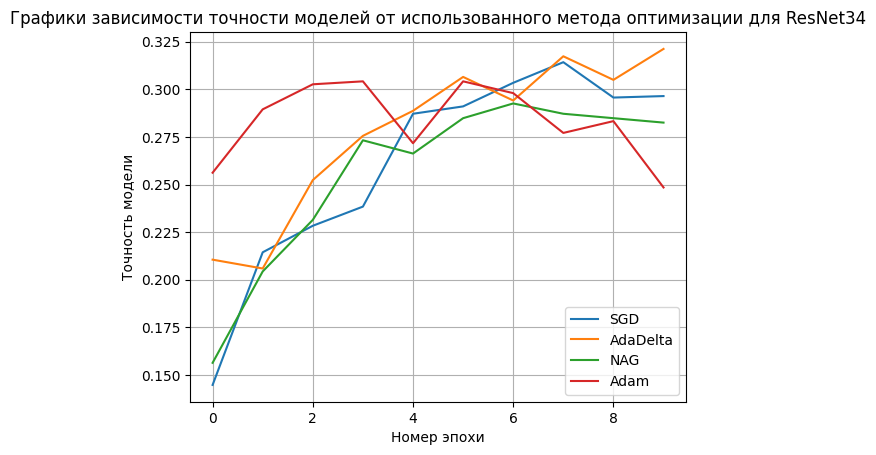

In [102]:
plt.plot(epoch_list, ResNet34_SGD_accuracies, label="SGD")
plt.plot(epoch_list, ResNet34_AdaDelta_accuracies, label="AdaDelta")
plt.plot(epoch_list, ResNet34_NAG_accuracies, label="NAG")
plt.plot(epoch_list, ResNet34_Adam_accuracies, label="Adam")

plt.title("Графики зависимости точности моделей от использованного метода оптимизации для ResNet34")
plt.xlabel("Номер эпохи")
plt.ylabel("Точность модели")
plt.grid(True)
plt.legend()
plt.show() 

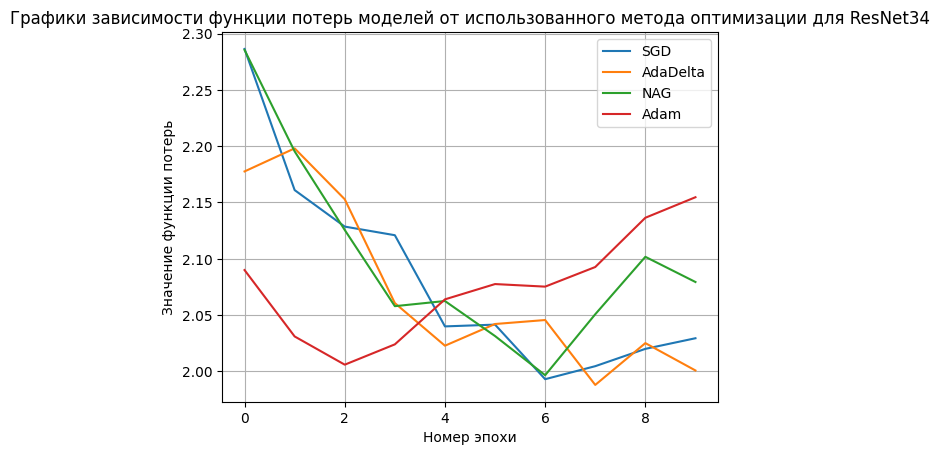

In [101]:
plt.plot(epoch_list, ResNet34_SGD_losses, label="SGD")
plt.plot(epoch_list, ResNet34_AdaDelta_losses, label="AdaDelta")
plt.plot(epoch_list, ResNet34_NAG_losses, label="NAG")
plt.plot(epoch_list, ResNet34_Adam_losses, label="Adam")

plt.title("Графики зависимости функции потерь моделей от использованного метода оптимизации для ResNet34")
plt.xlabel("Номер эпохи")
plt.ylabel("Значение функции потерь")
plt.grid(True)
plt.legend()
plt.show()